In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from cartopy import crs as ccrs
import cartopy.feature as cfeature
import mapclassify as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

import contextily as ctx

cmap = sns.blend_palette([(0.000, 0.627, 0.235), (0.412, 0.627, 0.235), 
                            (0.663, 0.780, 0.282), (0.957, 0.812, 0.000), 
                            (0.925, 0.643, 0.016), (0.835, 0.314, 0.118),
                            (0.780, 0.086, 0.118)], n_colors=5, as_cmap=True)


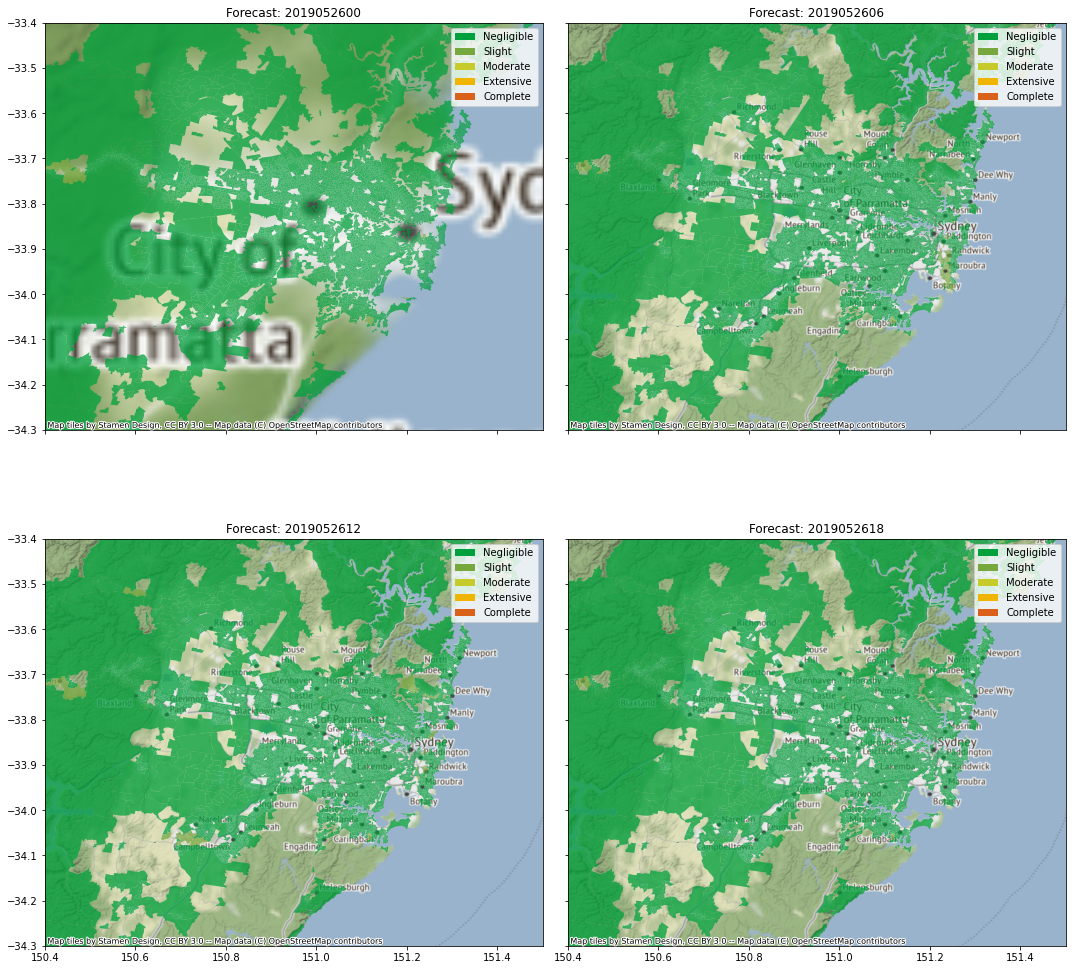

In [2]:
datapath = "C:/WorkSpace/data/impact/"
fcasttimes = ['2019052600', '2019052606', '2019052612', '2019052618'] #, '2019052700']
#fcasttimes = ['2020052300', '2020052306', '2020052312', '2020052318']
bins = [0., 0.02, 0.1, 0.2, 0.5, 1]
labels = ['Negligible', 'Slight', 'Moderate', 'Extensive', 'Complete']

cdict = dict((zip(labels, [cmap(int(255* x/len(labels))) for x in range(len(labels))])))

legend_elements = [Patch(facecolor=cdict[ctype], label=ctype) for ctype in labels]


fig, axes = plt.subplots(int(len(fcasttimes)/2),2, figsize=(15, 15), 
                         sharex=True, sharey=True,)

for ax, fcast in zip(axes.flatten(), fcasttimes):
    gdf = gpd.read_file(os.path.join(datapath, fcast, f"{fcast}.json"))
    gdf['category'] = pd.cut(gdf['structural_loss_ratio'], bins, right=False, labels=labels)
    gdf = gdf.sort_values('category')
    
    for ctype, data in gdf.groupby('category'):
        color = cdict[ctype]
        if len(data) > 0:
            data.plot(color=color, ax=ax, label=ctype, alpha=0.75, legend=True)

    ctx.add_basemap(ax, crs=gdf.crs.to_string())
    ax.set_title(f"Forecast: {fcast}")
    ax.set_xlim((150.4, 151.5)) # Sydney Metro
    ax.set_ylim((-34.3, -33.4))
    #ax.set_xlim((115.25, 116.25)) # Perth metro
    #ax.set_ylim((-32.5, -31.5))
    #ax.set_xlim((114.4, 117.4)) # Greater Perth 
    #ax.set_ylim((-33.4, -30.4))
    ax.legend(handles=legend_elements)
    
fig.tight_layout()

plt.savefig(os.path.join(datapath, "impact_forecast.20190526.png"), bbox_inches='tight')

C:\W10Dev\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
C:\W10Dev\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\W10Dev\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


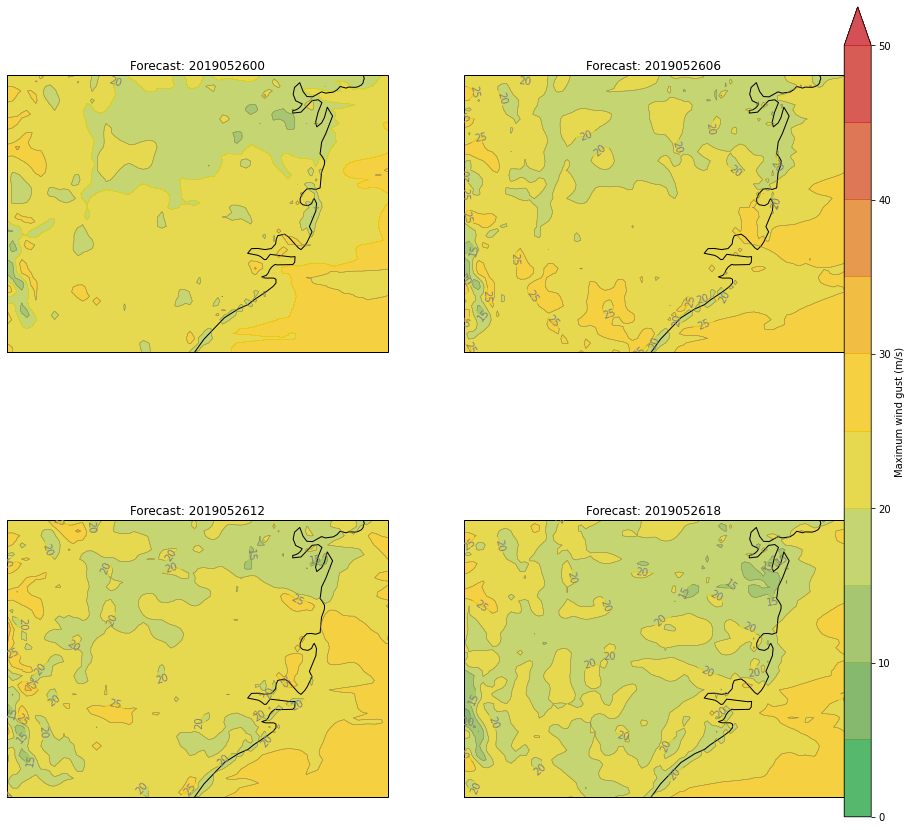

In [3]:
from netCDF4 import Dataset
hazardPath =  "C:/WorkSpace/data/hazard/"

levels = np.arange(0, 51, 5)

cmaphaz = sns.blend_palette([(0.000, 0.627, 0.235), (0.412, 0.627, 0.235), 
                            (0.663, 0.780, 0.282), (0.957, 0.812, 0.000), 
                            (0.925, 0.643, 0.016), (0.835, 0.314, 0.118),
                            (0.780, 0.086, 0.118)], n_colors=10, as_cmap=True)

fig, axes = plt.subplots(int(len(fcasttimes)/2),2, figsize=(15, 15), 
                         sharex=True, sharey=True, constrained_layout=True, 
                         subplot_kw={'projection': ccrs.PlateCarree()})

for ax, fcast in zip(axes.flatten(), fcasttimes):
    ds = Dataset(os.path.join(hazardPath, f"op_PSWG_{fcast[:-2]}_{fcast[-2:]}.nc"))
    
    ws = ds.variables['wndgust10m'][:]
    lon = ds.variables['lon2'][:]
    lat = ds.variables['lat'][:]
    xx, yy = np.meshgrid(lon, lat)
    cx = ax.contourf(xx, yy, ws, levels=levels,extend='max', cmap=cmaphaz, alpha=0.75, transform=ccrs.PlateCarree())
    cm = ax.contour(xx, yy, ws, levels=levels, colors='0.5', linewidths=0.5, transform=ccrs.PlateCarree())
    ax.clabel(cm, inline=1, fontsize=10, fmt='%.0f')
    ax.set_title(f"Forecast: {fcast}")
    ax.set_extent([150.4, 151.5, -34.3, -33.5], crs=ccrs.PlateCarree()) #Sydney Metro
    #ax.set_extent([115.25, 116.25, -32.5, -31.5], crs=ccrs.PlateCarree()) # Perth Metro
    #ax.set_extent([114.4, 117.4, -33.4, -30.4], crs=ccrs.PlateCarree()) # Greater Perth
    ax.coastlines(resolution='10m')
    ax.grid(True)
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.75])
fig.colorbar(cx, cax=cbar_ax, shrink=0.85, extend='max', label="Maximum wind gust (m/s)")# ax=axes.flat)
#plt.colorbar(cx, shrink=0.85, extend='max')
fig.tight_layout()
plt.savefig(os.path.join(hazardPath, "hazard_forecast.20190526.png"), bbox_inches='tight')